In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-15 22:38:07.459060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 22:38:07.459142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 22:38:07.460546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 22:38:07.469676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 22:38:08.533338: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:50]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)']

input_features_xyz = ['X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

ew_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
                                      train_val_split=0.8,
                                      input_stride=2,
                                      padding='none',
                                      transform_features=True,
                                      scale=True,
                                      per_object_scaling=False,
                                      input_history_steps=48,
                                      node_class_multipliers={'ID':1.0,'IK':1.0,'AD':1.0,'SS':1.0},
                                      input_future_steps=24, seed=181)

# ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
#                                       with_labels=True, pad_location_labels=0,
#                                       nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
#                                       train_val_split=0.8, input_stride=2, padding='none',
#                                       transform_features=False,
#                                       add_daytime_feature=False,
#                                       scale=True,
#                                       per_object_scaling=False,
#                                       node_class_multipliers={'ID':1.5,'IK':1.0,'AD':1.0,'SS':1.0},
#                                       input_history_steps=48,
#                                       input_future_steps=48,
#                                       seed=181,
#                                       deepcopy=True,
#                                       verbose=2)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: none
Horizons: 48-24 @ stride 2
Scaling: True  
Node Class Multipliers: {'ID': 1.0, 'IK': 1.0, 'AD': 1.0, 'SS': 1.0}
Sin-Cos-Transforming features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)', 'Longitude (deg)']
Padding node locations in non-binary fashion ([24.0, 34.0, 49.0, 70.0, 100.0, 70.0, 49.0, 34.0, 24.0])
Final input features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'True Anomaly (sin)', 'True Anomaly (cos)', 'Argument of Periapsis (sin)', 'Argument of Periapsis (cos)', 'Longitude (sin)', 'Longitude (cos)']
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-02-15 22:40:02.637073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:40:02.657962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:40:02.658039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:40:02.660188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:40:02.660296: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(655805, shape=(), dtype=int64)
(TensorSpec(shape=(None, 36, 11), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 11)]          0         
                                                                 
 conv1d (Conv1D)             (None, 31, 48)            3216      
                                                                 
 batch_normalization (Batch  (None, 31, 48)            192       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 31, 48)            0         
                                                                 
 dropout (Dropout)           (None, 31, 48)        

2024-02-15 22:40:10.419506: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2077590240 exceeds 10% of free system memory.


Epoch 1/60


2024-02-15 22:40:15.707220: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 22:40:17.304134: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5d500157a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 22:40:17.304188: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-15 22:40:17.310131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708033217.415209  392013 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


641/641 [==============================] - 27s 27ms/step - loss: 23.9232 - mse: 23.8184 - mae: 1.0300 - val_loss: 16.7861 - val_mse: 16.6584 - val_mae: 0.7011
Epoch 2/60
641/641 [==============================] - 17s 25ms/step - loss: 15.3027 - mse: 15.1524 - mae: 0.7317 - val_loss: 14.1099 - val_mse: 13.9369 - val_mae: 0.6171
Epoch 3/60
641/641 [==============================] - 21s 30ms/step - loss: 13.5526 - mse: 13.3532 - mae: 0.6507 - val_loss: 12.8551 - val_mse: 12.6299 - val_mae: 0.5416
Epoch 4/60
641/641 [==============================] - 21s 30ms/step - loss: 12.5457 - mse: 12.2962 - mae: 0.6291 - val_loss: 12.1032 - val_mse: 11.8276 - val_mae: 0.6393
Epoch 5/60
641/641 [==============================] - 21s 30ms/step - loss: 11.5634 - mse: 11.2674 - mae: 0.5691 - val_loss: 11.3727 - val_mse: 11.0567 - val_mae: 0.4989
Epoch 6/60
641/641 [==============================] - 22s 31ms/step - loss: 11.2744 - mse: 10.9362 - mae: 0.5759 - val_loss: 11.0083 - val_mse: 10.6469 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


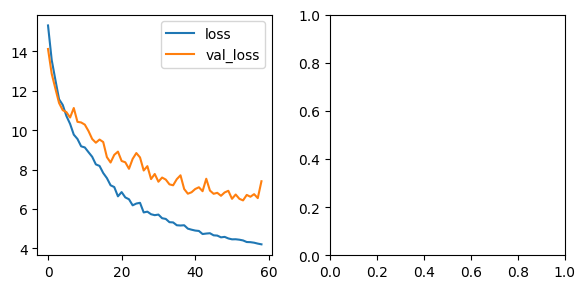

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(1024,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew,
                                                 conv1d_layers=[[48,6],[48,6],[48,6]], 
                                                 dense_layers=[64,32],
                                                 l2_reg=0.00025,
                                                 mixed_batchnorm=True,
                                                 mixed_dropout_dense=0.35,
                                                 mixed_dropout_cnn=0.3,
                                                 lr_scheduler=[0.003,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ew.summary()
# TODO: seed and dropout have a very strong impact on wether the model is able to learn at all
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=60, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          with_identifier=True,
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
labels = np.stack([element for element in val_ns.map(lambda x,y,z:x).as_numpy_iterator()])
print(labels.shape)

In [ ]:
print(labels[:10,3,:])

In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
print(train_ns.element_spec)

model_ns = prediction_models.STATEFUL_LSTM(train_ns, val_ns,
                                            dense_layers=[32,16],
                                            lstm_layers=[48,48],
                                            l2_reg=0.000,
                                            mixed_dropout_dense=0.25,
                                            mixed_dropout_lstm=0.25,
                                            lr_scheduler=[0.003,7500,0.9],
                                            seed=0)

model_ns.summary()

In [ ]:
model_ns.load_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:

hist = model_ns.fit(train_ns, val_ds=val_ns,
                    epochs=2,
                    eval_frequency=2,
                    verbose=1,
                    plot_hist=False)

In [5]:
train_ns, val_ns = ds_gen_ns.get_datasets(1024,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ns.element_spec)

2024-02-15 22:07:50.951802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:07:50.974748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:07:50.974823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:07:50.976918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 22:07:50.977009: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(643901, shape=(), dtype=int64)
(TensorSpec(shape=(None, 48, 8), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 43, 48)            2352      
                                                                 
 batch_normalization (Batch  (None, 43, 48)            192       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 43, 48)            0         
                                                                 
 dropout (Dropout)           (None, 43, 48)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 48)            13872     
                                                             

2024-02-15 22:07:58.748760: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1978063872 exceeds 10% of free system memory.


Epoch 1/60


2024-02-15 22:08:03.503637: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 22:08:05.649346: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f05ac3d7da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 22:08:05.649406: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-15 22:08:05.655408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708031285.757225  383206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-15 22:08:07.162922: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.12GiB with freed_by_count=0. The caller indica

628/629 [============================>.] - ETA: 0s - loss: 79.0402 - mse: 78.9280 - mae: 2.0087

2024-02-15 22:08:25.487336: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-15 22:08:25.535923: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


629/629 [==============================] - ETA: 0s - loss: 78.9906 - mse: 78.8784 - mae: 2.0079

2024-02-15 22:08:25.729329: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-15 22:08:25.780858: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


629/629 [==============================] - 29s 31ms/step - loss: 78.9906 - mse: 78.8784 - mae: 2.0079 - val_loss: 72.9774 - val_mse: 72.8313 - val_mae: 1.7428
Epoch 2/60
629/629 [==============================] - 20s 29ms/step - loss: 69.1611 - mse: 68.9832 - mae: 1.7349 - val_loss: 67.6201 - val_mse: 67.4072 - val_mae: 1.7704
Epoch 3/60
629/629 [==============================] - 20s 29ms/step - loss: 66.2577 - mse: 66.0067 - mae: 1.6597 - val_loss: 65.0212 - val_mse: 64.7357 - val_mae: 1.6569
Epoch 4/60
629/629 [==============================] - 19s 29ms/step - loss: 64.3449 - mse: 64.0212 - mae: 1.6031 - val_loss: 63.5461 - val_mse: 63.1853 - val_mae: 1.5419
Epoch 5/60
629/629 [==============================] - 19s 28ms/step - loss: 62.3516 - mse: 61.9543 - mae: 1.5527 - val_loss: 61.1929 - val_mse: 60.7597 - val_mae: 1.4447
Epoch 6/60
629/629 [==============================] - 20s 29ms/step - loss: 61.0391 - mse: 60.5716 - mae: 1.5263 - val_loss: 61.6956 - val_mse: 61.1897 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


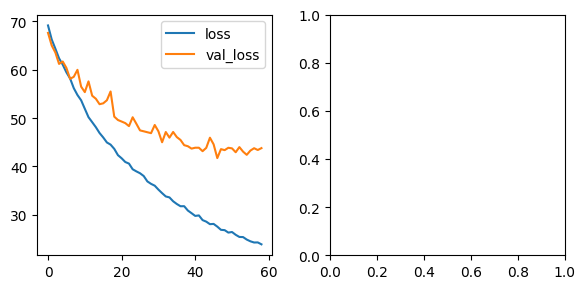

In [6]:
utils.set_random_seed(42)

model_ns = prediction_models.Dense_NN_regression(val_ns,
                                                 conv1d_layers=[[48,6],[48,6],[48,6]], 
                                                 dense_layers=[64,32],
                                                 l2_reg=0.00025,
                                                 mixed_dropout_dense=0.35,
                                                 mixed_batchnorm=True,
                                                 mixed_dropout_cnn=0.3,
                                                 lr_scheduler=[0.003,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=60, verbose=1, plot_hist=True, callbacks=[])
#23 35


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/10


315/315 [==============================] - 12s 32ms/step - loss: 24.4434 - mse: 23.8070 - mae: 0.7772 - val_loss: 36.1026 - val_mse: 35.4638 - val_mae: 1.0443
Epoch 2/10
315/315 [==============================] - 12s 32ms/step - loss: 24.4961 - mse: 23.8553 - mae: 0.7763 - val_loss: 37.3393 - val_mse: 36.6965 - val_mae: 0.9797
Epoch 3/10
315/315 [==============================] - 11s 32ms/step - loss: 24.3560 - mse: 23.7110 - mae: 0.7915 - val_loss: 35.8012 - val_mse: 35.1540 - val_mae: 0.8732
Epoch 4/10
315/315 [==============================] - 11s 31ms/step - loss: 24.1906 - mse: 23.5416 - mae: 0.7616 - val_loss: 36.5763 - val_mse: 35.9255 - val_mae: 0.9893
Epoch 5/10
315/315 [==============================] - 11s 32ms/step - loss: 24.2011 - mse: 23.5478 - mae: 0.7609 - val_loss: 36.9198 - val_mse: 36.2638 - val_mae: 0.8638
Epoch 6/10
315/315 [==============================] - 11s 32ms/step - loss: 24.0239 - mse: 23.3658 - mae: 0.7651 - val_loss: 36.2868 - val_mse: 35.6269 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


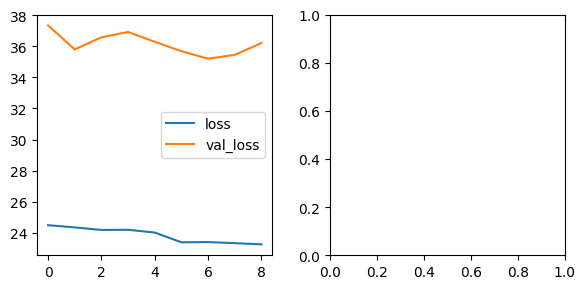

In [14]:
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/5


2024-02-15 22:59:57.756728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 203918 of 655805
2024-02-15 23:00:08.177427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 289098 of 655805
2024-02-15 23:00:24.139246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


641/641 [==============================] - ETA: 0s - loss: 4.1814 - mse: 3.5448 - mae: 0.1961

2024-02-15 23:00:49.865923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 81372 of 163981
2024-02-15 23:00:50.158771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


641/641 [==============================] - 64s 42ms/step - loss: 4.1814 - mse: 3.5448 - mae: 0.1961 - val_loss: 6.4884 - val_mse: 5.8530 - val_mae: 0.2318
Epoch 2/5
641/641 [==============================] - 24s 34ms/step - loss: 4.1374 - mse: 3.5033 - mae: 0.1931 - val_loss: 7.0150 - val_mse: 6.3820 - val_mae: 0.2432
Epoch 3/5
641/641 [==============================] - 18s 26ms/step - loss: 4.1297 - mse: 3.4980 - mae: 0.1929 - val_loss: 6.3886 - val_mse: 5.7584 - val_mae: 0.2089
Epoch 4/5
641/641 [==============================] - 17s 25ms/step - loss: 4.0861 - mse: 3.4572 - mae: 0.1931 - val_loss: 6.4218 - val_mse: 5.7939 - val_mae: 0.2479
Epoch 5/5
641/641 [==============================] - 17s 25ms/step - loss: 4.0746 - mse: 3.4478 - mae: 0.1900 - val_loss: 6.4842 - val_mse: 5.8582 - val_mae: 0.2285
Finished training after 5 epochs.
Evaluating model:
161/161 [==============================] - 2s 9ms/step - loss: 6.4842 - mse: 5.8582 - mae: 0.2285


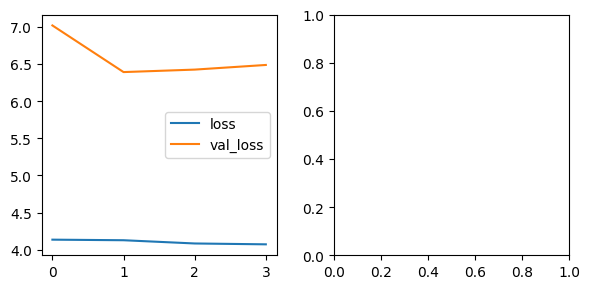

In [6]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=5, verbose=1, plot_hist=True, callbacks=[])

In [13]:
model_ew.model.save('submission/models/ew_localizer_cnn.hdf5')
pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_ns.save_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:
print(model_ns.model.optimizer.learning_rate)

In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [6]:
model_ns = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240209_192631-m9snmqvn/files\model_m9snmqvn.hdf5')


2024-02-10 01:47:09.140770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.166275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.166358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.168938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.169030: I external/local_xla/xla/stream_executor

In [ ]:
model_ew = tf.keras.models.load_model('submission/models/ew_localizer_cnn.hdf5')

In [7]:
object_limit = None
direction = 'EW'

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ew,
                                model=model_ew,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=[direction],
                                object_limit=object_limit,
                                only_ew_sk=False,
                                ds_batch_size=256,
                                prediction_batches=10,
                                verbose=1)

313/313 [==============================] - 1s 4ms/step


In [12]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=[direction],
                                            threshold=70.0,
                                            add_initial_node=True,
                                            clean_consecutives=True,
                                            deepcopy=False)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ew.val_keys))[:object_limit],
                                                 dirs=[direction],
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

# EW after 60 epochs:
# 50: TP: 606 FP: 21 FN: 45
# 55: TP: 605 FP: 20 FN: 46
# 60: TP: 605 FP: 19 FN: 46
# 65: TP: 603 FP: 15 FN: 48
# 70: TP: 601 FP: 11 FN: 50

# NS after 60 epochs:
# 50: TP: 328 FP: 183 FN: 101
# 55: TP: 327 FP: 149 FN: 102
# 60: TP: 326 FP: 123 FN: 103
# 65: TP: 321 FP: 103 FN: 108
# 70: TP: 320 FP: 88 FN: 109
# 75: TP: 314 FP: 72 FN: 115

Evaluator ignoring classifications
Precision: 0.98
Recall: 0.92
F2: 0.93
RMSE: 0.4633
TP: 601 FP: 11 FN: 50


In [9]:
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
for node in ['ID', 'AD', 'IK']:
    tp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'TP')])
    #fp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FP')])
    fn = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FN')])
    print(f"{node}: TP: {tp} FN: {fn}")

#EW:
# ID: TP: 114 FN: 42
# AD: TP: 264 FN: 13
# IK: TP: 203 FN: 15

#NS:  
# ID: TP: 112 FN: 104
# AD: TP: 0 FN: 0
# IK: TP: 185 FN: 28


ID: TP: 92 FN: 124
AD: TP: 0 FN: 0
IK: TP: 178 FN: 35


25/25 - 0s - 394ms/epoch - 16ms/step
(22,)


/home/david/Code/splid-challenge/base/localizer.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[timeindex-20:timeindex+20, 'keep'] = True
/home/david/Code/splid-challenge/base/localizer.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


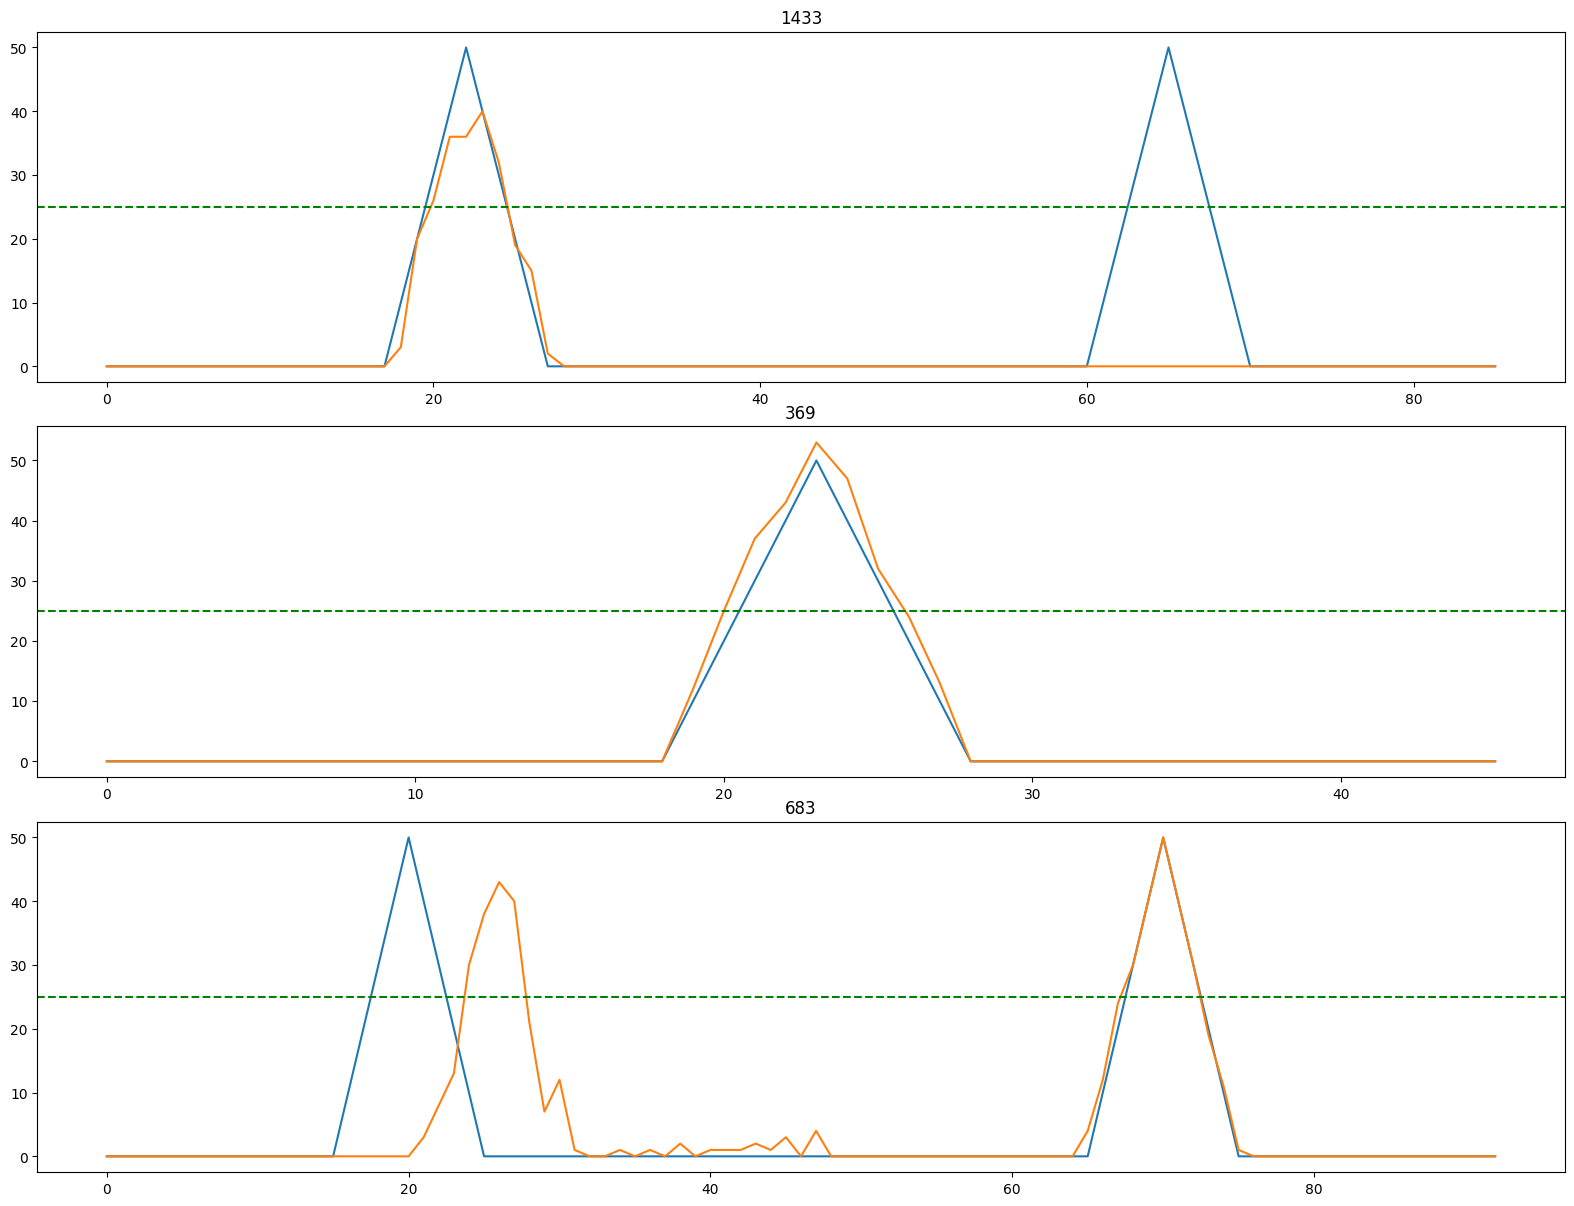

In [12]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ns,
                                model=model_ns,
                                label_features=['NS_Node_Location_nb'],
                                object_ids=['683','369','1433'],#ds_gen_ns.val_keys[100:150],
                                threshold=25.0,
                                zoom=True)

In [23]:
print("as")

as
